In [33]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np


from torchviz import make_dot, make_dot_from_trace

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

## Select Device ( GPU or CPU)

we will select device. there are two options: GPU or CPU. GPU technology is so faster than CPU technology. We will select GPU device. If your System is not include GPU technology, our function select CPU device.

In [2]:
device = torch.device( 'cuda:0' if torch.cuda.is_available() else 'cpu')

## Hyper Parameters
Hyper Paramaeters change each network and there is no rule to select hyper parameters. so we select most uses variable.

In [3]:
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001


## Define Dataset

In [5]:
train_dataset = torchvision.datasets.MNIST(root ='../data/',
                                          train = True,
                                          transform = transforms.ToTensor(),
                                          download = True )

test_dataset = torchvision.datasets.MNIST(root ='../data/',
                                          train = False,
                                          transform = transforms.ToTensor())


## Data Loader

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size= batch_size,
                                          shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset= test_dataset,
                                         batch_size= batch_size,
                                         shuffle= False)

## Visualization Dataset

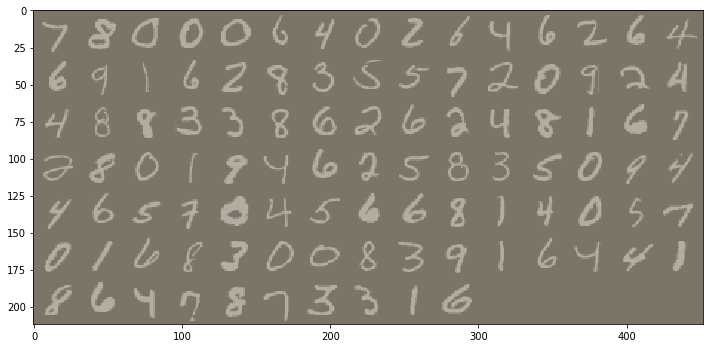

In [42]:
for images, labels in train_loader:
    break
im = make_grid(images,nrow=15)
inv_normalize = transforms.Normalize(
        mean= [-0.485/0.225,
              -0.456/0.224,
              -0.406/0.225],
        std= [1/0.225, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,24))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

## Build Network

In [7]:
class CNN(nn.Module):
    
    def __init__(self, num_classes = 10 ):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size= 5, stride = 1, padding = 2 ),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size= 5, stride = 1, padding = 2 ),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        
        return out

## Visualization Network

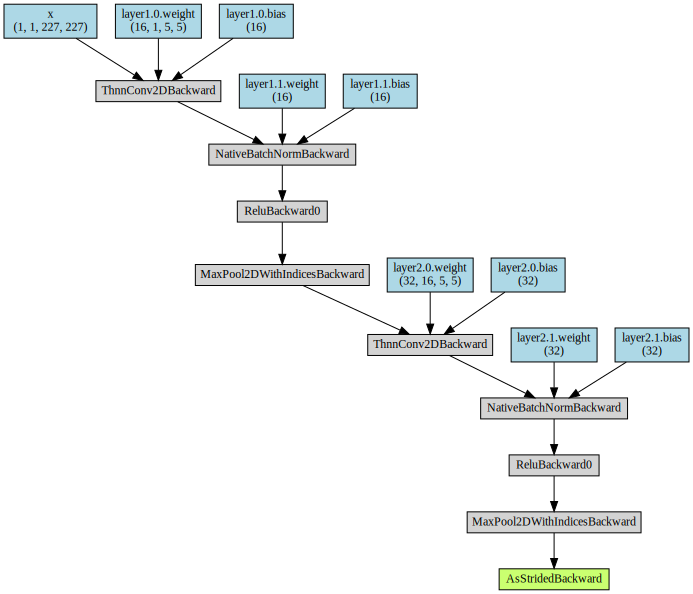

In [18]:
model = CNN(num_classes)

x = torch.randn(1, 1, 227, 227).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

In [21]:
model = CNN(num_classes).to(device)


## Loss and Optimizer

In [22]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## Training

In [25]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 4.5694
Epoch [1/5], Step [200/600], Loss: 3.8766
Epoch [1/5], Step [300/600], Loss: 3.5492
Epoch [1/5], Step [400/600], Loss: 3.1011
Epoch [1/5], Step [500/600], Loss: 2.9961
Epoch [1/5], Step [600/600], Loss: 3.0608
Epoch [2/5], Step [100/600], Loss: 2.5096
Epoch [2/5], Step [200/600], Loss: 3.1002
Epoch [2/5], Step [300/600], Loss: 2.7825
Epoch [2/5], Step [400/600], Loss: 2.6510
Epoch [2/5], Step [500/600], Loss: 2.4090
Epoch [2/5], Step [600/600], Loss: 2.4614
Epoch [3/5], Step [100/600], Loss: 2.3213
Epoch [3/5], Step [200/600], Loss: 2.4479
Epoch [3/5], Step [300/600], Loss: 2.2469
Epoch [3/5], Step [400/600], Loss: 2.2701
Epoch [3/5], Step [500/600], Loss: 2.4617
Epoch [3/5], Step [600/600], Loss: 2.1176
Epoch [4/5], Step [100/600], Loss: 2.2220
Epoch [4/5], Step [200/600], Loss: 2.3293
Epoch [4/5], Step [300/600], Loss: 2.0645
Epoch [4/5], Step [400/600], Loss: 1.9491
Epoch [4/5], Step [500/600], Loss: 2.2446
Epoch [4/5], Step [600/600], Loss:

## Testing

In [27]:
model.eval()

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += ( predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
    
torch.save(model.state_dict(), 'model.ckpt')
    

Test Accuracy of the model on the 10000 test images: 30.25 %


In [83]:
def predict_image(image):
    i = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        i += 1
        if i == 1:
            return 0
        
    output = model(images)
    index = output.data.cpu().numpy().argmax()
    return index

In [84]:
def get_random_images(num):
    
    class_names = train_dataset.classes
    indices = list(range(len(test_dataset)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_dataset, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

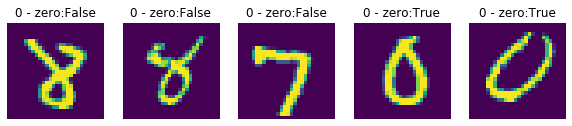

In [85]:
to_pil = transforms.ToPILImage()
class_names = train_dataset.classes
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(class_names[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()